In [1]:
#import sys
#sys.path.append('/home/itsara/env/lib/python2.7/site-packages')

import numpy as np
import pandas as pd
import math
import itertools
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import keras
import matplotlib.pyplot as plt2
from keras.callbacks import ModelCheckpoint
import h5py

from keras.models import load_model

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["mv close"] = df.close
df.drop(['volume','close'], 1, inplace=True)
df.head()

,symbol,open,low,high,mv close
date,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,114.970001


In [3]:
symbols = list(set(df.symbol))
symbols[:5]

['HSIC', 'ROP', 'LLY', 'TMO', 'BK']

In [4]:
SYM = 'CCL'
df = df[df.symbol == SYM]
df.drop(['symbol'],1,inplace=True)
df.head()

,open,low,high,mv close
date,,,,
2010-01-04,32.290001,31.959999,32.759998,32.060001
2010-01-05,32.279999,32.200001,32.540001,32.369999
2010-01-06,32.290001,31.750000,32.570000,31.790001
2010-01-07,32.119999,31.900000,32.360001,32.139999
2010-01-08,32.820000,32.639999,33.290001,33.220001


In [5]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
#    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['mv close'] = min_max_scaler.fit_transform(df['mv close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head()

,open,low,high,mv close
date,,,,
2010-01-04,0.125377,0.129909,0.115340,0.102644
2010-01-05,0.125000,0.138973,0.106882,0.114697
2010-01-06,0.125377,0.121979,0.108035,0.092146
2010-01-07,0.118976,0.127644,0.099962,0.105754
2010-01-08,0.145331,0.155589,0.135717,0.147745


In [6]:
def load_data(stock, seq_len):
    n_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1
    result = []
    
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]

    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_features))  

    return [x_train, y_train, x_test, y_test]

In [7]:
n_features = 4
prev_days = 7
X_train, y_train, X_test, y_test = load_data(df, prev_days)
print (X_train[0], y_train[0])

[[0.12537658 0.12990933 0.11534018 0.1026439 ]
 [0.125      0.13897285 0.10688201 0.1146967 ]
 [0.12537658 0.12197885 0.10803537 0.09214623]
 [0.1189759  0.1276435  0.09996159 0.10575424]
 [0.14533136 0.15558909 0.13571707 0.14774499]
 [0.17432232 0.18051356 0.14994233 0.15552092]
 [0.15097899 0.15030211 0.12879666 0.13452571]] 0.1800155202183329


In [8]:
def build_model(layers):
    p = 0.25
    model = Sequential()

    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(p))

    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(p))

    model.add(Dense(64,activation='relu'))
    model.add(Dense(1,activation='linear'))

    model.compile(loss='mse',optimizer='adagrad', metrics=['mse'])

    return model

model = build_model([n_features, prev_days, 1])

In [9]:
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='auto')

model.fit(X_train, y_train, batch_size = 64, epochs = 100, validation_split = 0.05, verbose=1, callbacks=[checkpoint])

model.load_weights("weights.best.hdf5")
model.compile(loss='mse',optimizer='adagrad', metrics=['mse'])

Train on 1500 samples, validate on 79 samples
Epoch 1/100
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0621 - mean_squared_error: 0.0621 - val_loss: 0.0062 - val_mean_squared_error: 0.0062

Epoch 00001: val_mean_squared_error improved from inf to 0.00618, saving model to weights.best.hdf5
Epoch 2/100
1500/1500 [==============================] - 1s 627us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0064 - val_mean_squared_error: 0.0064

Epoch 00002: val_mean_squared_error did not improve
Epoch 3/100
1500/1500 [==============================] - 1s 666us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0073 - val_mean_squared_error: 0.0073

Epoch 00003: val_mean_squared_error did not improve
Epoch 4/100
1500/1500 [==============================] - 1s 699us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0077 - val_mean_squared_error: 0.0077

Epoch 00004: val_mean_squared_error did not improve
Epoch 5/100
1500/1500 [=====

1500/1500 [==============================] - 1s 801us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0082 - val_mean_squared_error: 0.0082

Epoch 00035: val_mean_squared_error did not improve
Epoch 36/100
1500/1500 [==============================] - 1s 670us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0055 - val_mean_squared_error: 0.0055

Epoch 00036: val_mean_squared_error did not improve
Epoch 37/100
1500/1500 [==============================] - 1s 694us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0057 - val_mean_squared_error: 0.0057

Epoch 00037: val_mean_squared_error did not improve
Epoch 38/100
1500/1500 [==============================] - 1s 685us/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0056 - val_mean_squared_error: 0.0056

Epoch 00038: val_mean_squared_error did not improve
Epoch 39/100
1500/1500 [==============================] - 1s 658us/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0

1500/1500 [==============================] - 1s 701us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0039 - val_mean_squared_error: 0.0039

Epoch 00071: val_mean_squared_error improved from 0.00393 to 0.00385, saving model to weights.best.hdf5
Epoch 72/100
1500/1500 [==============================] - 1s 683us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0081 - val_mean_squared_error: 0.0081

Epoch 00072: val_mean_squared_error did not improve
Epoch 73/100
1500/1500 [==============================] - 1s 688us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0040 - val_mean_squared_error: 0.0040

Epoch 00073: val_mean_squared_error did not improve
Epoch 74/100
1500/1500 [==============================] - 1s 661us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0046 - val_mean_squared_error: 0.0046

Epoch 00074: val_mean_squared_error did not improve
Epoch 75/100
1500/1500 [==============================] - 1s 656us/step - los

In [10]:
diff=[]
ratio=[]
predict = model.predict(X_test)
for d in range(len(y_test)):
    pred = predict[d][0]
    ratio.append((y_test[d]/pred)-1)
    diff.append(abs(y_test[d]- pred))

In [11]:
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["mv close"] = df.close
df.drop(['volume', 'close'], 1, inplace=True)
df = df[df.symbol == SYM]
df.drop(['symbol'],1,inplace=True)

def denormalize(df, normalized_value): 
    df = df['mv close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)

    min_max_scaler = preprocessing.MinMaxScaler()
    _ = min_max_scaler.fit_transform(df)
    denorm = min_max_scaler.inverse_transform(normalized_value)
    return denorm

new_pred = denormalize(df, predict)
newy_test = denormalize(df, y_test)

In [12]:
def evaluation(model, X_test, y_test):
    score = model.evaluate(X_test, y_test, verbose=0)
    print('MSE: %.5f (RMSE: %.2f)' % (score[0], math.sqrt(score[0])))
    return score[0], math.sqrt(score[0])

evaluation(model, X_test, y_test)

MSE: 0.00203 (RMSE: 0.05)


(0.002028955638275615, 0.045043930093583255)

Buy [49.130001]
Buy [49.490002]
Sell [48.709999]
Balance: [84939.22597879]
Sell [49.049999]
Balance: [88669.50263082]
Sell [49.529999]
Balance: [91494.58829767]
Sell [49.490002]
Balance: [93611.69154003]
Sell [49.16]
Balance: [95188.93125292]
Sell [48.389999]
Balance: [96353.3326178]
Buy [49.220001]
Buy [49.740002]
Sell [50.389999]
Balance: [82354.82460953]
Sell [50.279999]
Balance: [86846.11778275]
Sell [51.049999]
Balance: [90266.17322072]
Sell [49.599998]
Balance: [92758.35852247]
Sell [49.990002]
Balance: [94642.194509]
Buy [49.93]
Buy [50.330002]
Buy [49.549999]
Buy [50.029999]
Buy [49.91]
Sell [50.830002]
Balance: [58799.35244727]
Sell [49.630001]
Balance: [69166.55294384]
Buy [47.59]
Buy [48.599998]
Buy [47.740002]
Buy [48.049999]
Buy [48.330002]
Buy [47.75]
Buy [47.07]
Sell [47.150002]
Balance: [24414.52165665]
Buy [46.639999]
Buy [46.52]
Buy [47.259998]
Sell [47.810001]
Balance: [24815.71833537]
Sell [48.5]
Balance: [43696.11439412]
Sell [48.650002]
Balance: [57900.20675524]
S

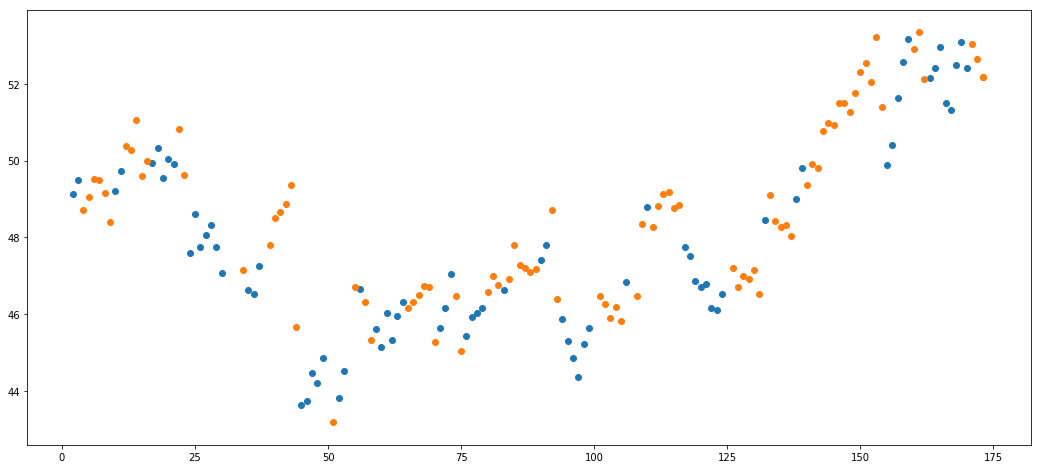

In [13]:
import random
random.seed(1997)

balance = 100000.0
cash_list= []
volume = 0
buyx = []
buyy =[]
selx = []
sely = []
for i in range(2,len(new_pred) - 1):
    prediction = new_pred[i]
    rand = random.randint(1, 100)
    if (prediction < new_pred[i-1] and balance != 0) or rand <= 5:
        if balance <= 10000:
            money = balance
            balance = 0
        else:
            money = 10000
            balance = balance - 10000
        volume += money / newy_test[i]
        buyx.append(i)
        buyy.append(newy_test[i])
        print("Buy " + str(newy_test[i]))
    elif(volume > 0 and prediction > new_pred[i-1] and prediction * 1.002 > new_pred[i-2]) or rand > 95:
        forSell = volume/4.0
        volume = volume*3.0/4.0
        balance += forSell * newy_test[i]
        selx.append(i)
        sely.append(newy_test[i])
        print("Sell " + str(newy_test[i]))
        print("Balance: " + str(balance))

if(volume != 0):
    balance += volume * newy_test[i]
    volume = 0
    selx.append(i)
    sely.append(newy_test[i])
    print("Sell : " + str(newy_test[i]))
    print("Balance : " + str(balance))
    
print("Balance : " + str(balance))
plt2.figure(figsize=(18,8))
plt2.scatter(buyx, buyy)
plt2.scatter(selx, sely)

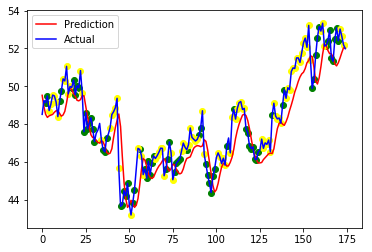

In [14]:
plt2.plot(new_pred,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.scatter(buyx, buyy, color='green')
plt2.scatter(selx, sely, color='yellow')
plt2.show()